In [32]:
import numpy as np
import pandas as pd
import json
import codecs
import datetime
import os
import sys

In [23]:
sys.path.append('.')

In [25]:
import matplotlib as mpl
import matplotlib.pyplot as plt


In [26]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

In [27]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,9), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

In [28]:
path = '/Users/smuel/AndroidStudioProjects/LuckyMeIntgratedSDK/metadata_init_phase/'

In [43]:
from statsmodels.tsa.seasonal import seasonal_decompose


In [44]:
res = seasonal_decompose(df.CALL_DURATION, model='additive', period=1)

In [45]:
y = df.groupby(pd.Grouper(key='CALL_DATE_TIME', freq='D')).agg({'CALL_NUMBER' : ['count']}).to_numpy().T[0]

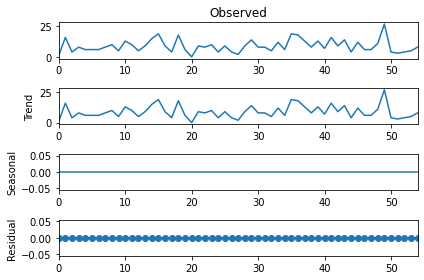

In [46]:
res = seasonal_decompose(y, model='additive', period=1)
res.plot()
plt.show()

In [1]:
from vector_creator.raw_to_df.rawdata_to_df import create_df_from_init_metadata 
from vector_creator.score_vectors.score_vectors_assembly import run_score_vector, score_vector_constructor
from vector_creator.preprocess.utils import calc_number_of_days

In [2]:
path = '/Users/smuel/AndroidStudioProjects/LuckyMeIntgratedSDK/metadata_init_phase/'

In [11]:
loc, df_dict = create_df_from_init_metadata(raw_data_lst[0][0], raw_data_lst[0][1], raw_data_lst[0][2])

In [15]:
df_dict.keys()

dict_keys(['05fa68e5-0ba3-4783-9c07-42740c4914c6_CallLogs', '05fa68e5-0ba3-4783-9c07-42740c4914c6_ImgMetaData', '05fa68e5-0ba3-4783-9c07-42740c4914c6_InstallApps'])

In [17]:
df0 = df_dict['05fa68e5-0ba3-4783-9c07-42740c4914c6_CallLogs'].sort_values('CALL_DATE_TIME')

In [19]:
df1 = df0.set_index('CALL_DATE_TIME')

In [26]:
(df1.index[-1] - df1.index[0]).days

53

In [30]:
calc_number_of_days(df0, 'CALL_DATE_TIME')

53

In [3]:
res0 = score_vector_constructor(path)

call-logs:  493
days :  53
05fa68e5-0ba3-4783-9c07-42740c4914c6 processed
call-logs:  3
days :  7
12fa7561-2e77-4334-b9e1-6858ed27570f call-logs to small to process
call-logs:  1400
days :  393
1362474c-0fb5-4932-a33d-5a30f23ac7e3 processed
call-logs:  189
days :  356
17ac0e20-b292-492c-9adc-faf60a068926 processed
call-logs:  813
days :  373
199ea69c-5e20-4b53-9bfb-0534aaeb68d6 processed
call-logs:  1049
days :  600
1abd59a3-553f-43db-a329-90c28c72afdd processed
call-logs:  2000
days :  362
20380cd2-055e-4f3a-a339-90a1c7df4e1a processed
call-logs:  2500
days :  182
236b91d2-cefb-405a-9de5-a3673ef1c736 processed
call-logs:  38
days :  463
25174909-3427-42d2-9e14-65f7c95f240b processed
call-logs:  15
days :  34
25ba2284-51e3-4eb9-a2c8-fa3a0eaeeca9 call-logs to small to process
call-logs:  2710
days :  108
2afbf7b0-6202-49bb-814f-ddba906bab48 processed
call-logs:  0
2afc4c23-161f-4fc5-b4ba-e567f5327d22 call-logs to small to process
call-logs:  217
days :  953


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


36f05b2e-4164-49a6-ba0c-d78997ecdcae processed
call-logs:  277
days :  412
3e4c39d0-d2ec-45c3-91cc-4c80ccf171be processed
call-logs:  24
days :  668
588aeafe-5c4d-4bc9-84c5-8ae28029c733 processed
call-logs:  918
days :  442
5e0b1bf2-2aba-4745-b91f-916554d51e9f processed
call-logs:  167
days :  608
759240f7-1248-4334-aad5-fd384b524d3d processed


In [4]:
len(res0)

64

In [5]:
len(res0.columns)

14

In [6]:
res0.to_csv('/Users/smuel/AndroidStudioProjects/LuckyMeIntgratedSDK/score_vec.csv')

In [3]:
import oci
import json
from oci.config import validate_config

In [33]:
df = pd.DataFrame({'empty' : []})

In [39]:
df.empty

True